In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit


On s'intéresse à approximer la solution de l'équation de transport suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = \epsilon \frac{\partial^2 u}{\partial x^2} \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [85]:
#La Solution Iniciale:
@njit(cache=True)
def u0(x):
    if  x>=0.1 and x <= 0.2:
        return 10.
    else: return 0.

@njit(cache=True)
def u0_Gauss(x,N):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin((N-1) * (L - l) * np.pi * x / (L - l))


# Le flux Exacte:
@njit(cache=True)
def F(u,a):
    return a*u

# Les Flux des schemas:
@njit(cache=True)
def Rusanov(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a))-a*(ud-ug)

@njit(cache=True)
def Rusanov2(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-a*(ud-ug))

@njit(cache=True)
def Roe(ug,ud,a,dx,dt):
    if a >= 0:
        return F(ug,a)
    else:
        return F(ud,a)
    
@njit(cache=True)
def LF(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dx/(dt))*(ud-ug))
       
@njit(cache=True)
def LFM(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-0.5*(dx/(dt))*(ud-ug))
       
    
@njit
def LW(ug,ud, a, dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dt/dx)*(a**2)*(ud-ug))


@njit(cache=True)
def VFD(ug,ud, a, dx,dt):
    return F(ug,a)

@njit(cache=True)
def departure(dt, alpha, X, a):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0
    kit = 0

    while aux > eps:
        x1 = xmp - dt * alpha * a
        aux = np.max(np.abs(x1 - x0))

        x0 = x1
        kit += 1

    return x0, kit
@njit(cache=True)
def FvcFlux(N, X, alpha, dt, u, a):
    F = np.zeros(N - 1)
    up = np.zeros(N - 1)
    
    # Characteristics foot
    x0, _ = departure(dt, alpha, X, a)

    # Interpolation procedure
    ui = np.interp(x0, X, u)

    # Predictor stage
    for i in range(N - 1):
        up[i] = ui[i]

    # Corrector stage
    for i in range(N - 1):
        F[i] = a * up[i]

    return F

      
 
@njit(cache=True)
def VFC(U0, T,  N, alpha ,CFL , dx):
    if epsilon != 0 and a!=0:
        Dt1  = (dx/(2*a*alpha))
        Dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon)
        Dt  = min(Dt1,Dt2)
    else:
        if epsilon == 0:
            Dt  = (dx/(2*a*alpha))
        elif a == 0:
            Dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    temps = 0
    
    while temps < T:
        temps += min(Dt,T-Dt)
        for i in range(1,N-1):
            X1 = X[i-1:i+2]
            u  = Un[i-1:i+2]
            F  = FvcFlux(3, X1, alpha, Dt, u, a)
            Fg = F[0]
            Fd = F[1]
            Unp1[i]=Un[i]-Dt/dx*(Fd-Fg)+ epsilon * (Dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])


        Unp1[0] = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        Un = Unp1.copy()
    return Un

#@njit(cache=True)
def Solver(U0, T, l, L, a, N, CFL, dx, scheme):
  

    if scheme == 0:
        flux = Roe 
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 1:
        flux = Rusanov
        if epsilon != 0 and a!=0:
            dt  = 0.5 * CFL *(dx / np.abs(a))
        else:
            if epsilon == 0:
                dt  = 0.5 * CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 2:
        flux = Rusanov2
        if epsilon != 0 and a!=0:
            dt  = CFL *(dx / np.abs(a))
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.abs(a)
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 3:
        flux = LF
        if epsilon != 0 and a!=0:
            dt  = 0.5*CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    elif scheme == 4:
        flux = LFM
        if epsilon != 0 and a!=0:
            dt  = 0.25*CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))
        else:
            if epsilon == 0:
                dt  = 0.5 * CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)
        
    elif scheme == 5:
        flux = LW
        dt1 =  CFL*dx/np.abs(a)
        dt2 =  CFL * 0.5 * dx**2 / np.abs(epsilon)
        dt  =  min(dt1,dt2)
    elif scheme == 6:
        flux = VFD
        if epsilon != 0 and a!=0:
            dt  = CFL /(np.abs(a)/dx + 2 * np.abs(epsilon)/(dx**2))
        else:
            if epsilon == 0:
                dt  = CFL *(dx / np.abs(a))
            elif a == 0:
                dt  = CFL * 0.5 * dx**2 / np.abs(epsilon)

    
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    while temps < T:
        dt = min(dt, T - temps)
        temps += dt

        for i in range(1, N - 1):
            Fd = flux ( Un[i], Un[i + 1], a, dx, dt )
            Fg = flux ( Un[i - 1], Un[i], a, dx, dt )

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * (dt / (dx**2)) * (Un[i + 1] - 2 * Un[i] + Un[i - 1])

        Unp1[0] = 0#Unp1[1]
        Unp1[N - 1] = 0#Unp1[N - 2]

        Un[:] = Unp1[:]

    return Un

  
######################################################################################
T       =  1/4
l       =  0
L       =  1
a       =  2
epsilon =  0.01
N       =  101
CFL     =  1/2
alpha   =  0.7
X       =  np.linspace(l,L,N)
dx      =  (L-l)/(N-1)
U0      =  np.array([u0(x) for x in X])




fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1, ("VFD",6):1}

f={}
for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0, T, l, L, a, N, CFL, dx, i[1])   
    
U_VFC = VFC(U0, T,  N, alpha ,CFL , dx)

UExact=np.array([u0(x-T*a) for x in X])


/tmp/ipykernel_53270/2765947823.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  dt  = 0.5*CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))
/tmp/ipykernel_53270/2765947823.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  dt  = 0.25*CFL /(np.abs(0.5*a/dx -epsilon/(dx**2)))


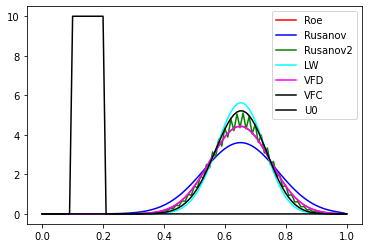

In [86]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":1, "LF":0, "LFM":0, "LW":1, "VFD":1 }

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, U_VFC, '-k',  label='VFC')
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.4, 0.6])  
#plt.ylim([-0.5, 11])  

plt.legend()
plt.pause(0.1)


In [87]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 18.582929387916025,
 'Rusanov': 16.757159941924055,
 'Rusanov2': 19.29817653271406,
 'LF': 707.8135347674555,
 'LFM': 704.2904230500369,
 'LW': 20.966916745456395,
 'VFD': 18.582929387916025}